# ADA final exam

## Deadline
_Friday, January 19, 2018, at 19:15 CET_


## Important notes

* Don't forget to add a textual description of your thought process, the assumptions you made, and your results!
* Please write all your comments in English, and use meaningful variable names in your code.
* As we have seen during the semester, data science is all about multiple iterations on the same dataset. Do not obsess over small details in the beginning, and try to complete as many tasks as possible during the first 2 hours. Then, go back to the obtained results, write meaningful comments, and debug your code if you have found any glaring mistake.
* You cannot leave the room in the first and last 15 minutes.
* You can use all the online resources you want except for communication tools (emails, web chats, forums, phone, etc.). We will monitor the network for unusual activities.
* Remember, this is not a homework assignment -- no teamwork allowed!

## Submission
* Make sure you upload your iPython Notebook (1 file) with [this form](https://goo.gl/forms/JKPX74ZH707sB7Up1) at the end of the exam, with all the cells already evaluated (except for the Spark-related question 1.4).
* Complete all the fields in the form, and name your file following the format "NameSurname_sciper.ipynb". The form will be open to submissions until 19:20 (strict deadline). Late submissions will not be accepted.

# Design the Pokedex 2.0

![banner](images/dataset-cover.jpg)

Pokémon are small creatures that fight in competitions. All Pokémon have different numerical characteristics (strength of attack, defense, etc.) and belong to one or two so-called classes (water, fire, etc.).
[Professor Oak](https://www.pojo.com/cartoon/Oak.gif) is the inventor of the [Pokedex](https://en.wikipedia.org/wiki/Gameplay_of_Pok%C3%A9mon#Pok%C3%A9dex), a useful portable device that keeps information about all the Pokémon available. As his lead data scientist, you just received a request from him asking you to update the software on all Pokedex devices. In this exam, you will work toward improving the Pokedex by (1) exploring a dataset of Pokémon and the battles they fight, (2) developing a model for predicting the outcome of battles between Pokémon, and (3) devising a method for ranking Pokémon by their overall strength.

## Dataset description
Professor Oak has dumped the memory of one Pokedex device, resulting in the dataset you’ll work with in this exam.

### [pokemon.csv](pokemon.csv)

In this file, each row represents the features of one Pokémon.

* pid: Numeric - ID of the Pokémon
* HP: Numeric - Health points
* Attack: Numeric - Strength of the regular attack
* Defense: Numeric - Strength of the regular defense
* Sp. Atk: Numeric - Strength of the special attack
* Sp. Def: Numeric - Strength of the special defense
* Speed: Numeric - Moving speed
* Legendary: Boolean - ‘True’ if the Pokémon is rare
* Class 1: Categorical - Pokémon class
* Class 2: Categorical - Pokémon class

Please note that a Pokémon can have either one or two classes. If a Pokémon has two classes, they are both considered to have the same importance.

### [combats.csv](combats.csv)

In this file, each row represents the outcome of one battle between two Pokémon.

* First_pokemon: Numeric - ID (match with pid)
* Second_pokemon: Numeric - ID (match with pid)
* Winner: Numeric - ID of the winner

### Good luck!


In [1]:
%matplotlib inline

# General
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For graph-related stuff
import networkx as nx

# For regression analyses and statistical tests
import scipy.stats as stats
import statsmodels.stats
import statsmodels.formula.api as smf

# For classification
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## Question 1: Exploring the data - 30 points
In this part, you will explore the data to address the curiosities of the demanding Professor Oak.

1. (6 points) Explore the data and report some descriptive statistics (e.g., use df.describe(), report the number of classes, summarize the attack and defense distributions, etc.). This will be useful later in your analysis.
2. (4 points) Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,
   1. visualize the relation between these two variables using an appropriate plot;
   2. list the names of the 3 Pokémon with highest attack-over-defense ratio;
   3. list the names of the 3 Pokémon with lowest attack-over-defense ratio;
   4. list the names of the 10 Pokémon with the largest number of victories.
3. (10 points) Professor Oak suspects that Pokémon in the _grass_ class have a stronger regular attack than those in the _rock_ class. Check if he is right and convince him of your conclusion with statistical arguments.
   Note: If there are Pokémon that are in both classes, discard them.
   Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.
4. (10 points) Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories.
   Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called `pokemon` and `combats`, with the same schema as the small CSV files you’ve been working with above.


In [14]:
pokemons = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')


# 1
Explore the data and report some descriptive statistics (e.g., use df.describe(), report the number of classes, summarize the attack and defense distributions, etc.). This will be useful later in your analysis.

In [8]:
pokemons.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [21]:
print('number of classes', len(pokemons['Class 1'].unique()))
print('possible classes: ', pokemons['Class 1'].unique())

number of classes 18
possible classes:  ['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']


In [22]:
pokemons.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


Text(0.5, 1.0, 'Attack value distribution')

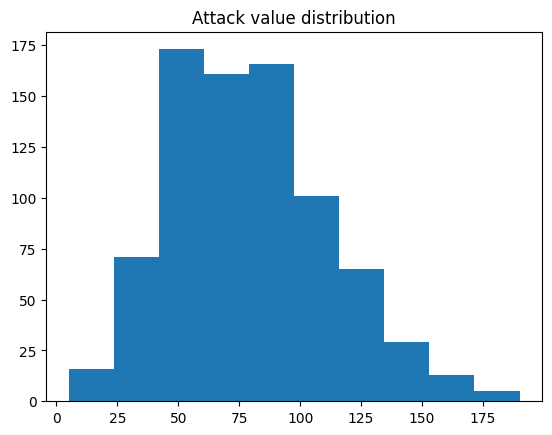

In [27]:
plt.hist(pokemons['Attack'])
plt.title('Attack value distribution')


Text(0.5, 1.0, 'Defense values distribution')

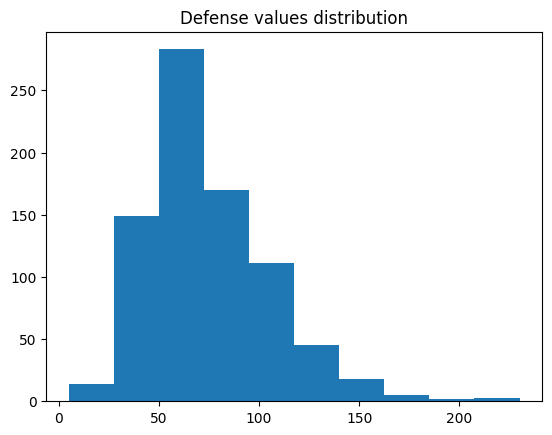

In [25]:
plt.hist(pokemons['Defense'])
plt.title('Defense values distribution')

# 2
Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,
   1. visualize the relation between these two variables using an appropriate plot;
   2. list the names of the 3 Pokémon with highest attack-over-defense ratio;
   3. list the names of the 3 Pokémon with lowest attack-over-defense ratio;
   4. list the names of the 10 Pokémon with the largest number of victories.
   

Text(0.5, 1.0, 'attack vs defense value of the pokemons')

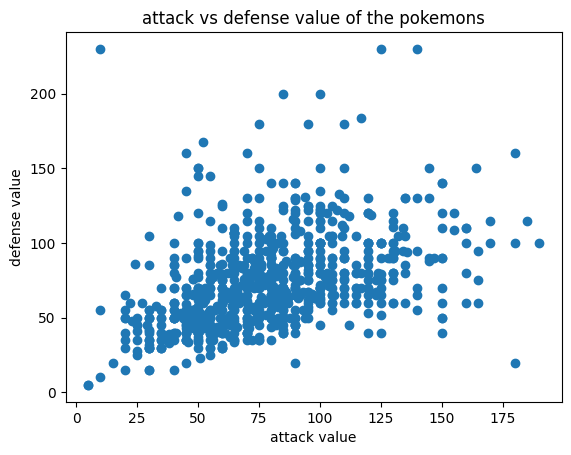

In [29]:
plt.scatter(pokemons['Attack'], pokemons['Defense'])
plt.xlabel('attack value')
plt.ylabel('defense value')
plt.title('attack vs defense value of the pokemons')

In [40]:
pokemons['attack_over_defense_ratio'] = pokemons['Attack']/pokemons['Defense']
pokemons.sort_values(by = 'attack_over_defense_ratio', ascending= False)

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,attack_over_defense_ratio
429,430,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,True,9.000000
347,348,Carvanha,Water,Dark,45,90,20,65,20,65,False,4.500000
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,False,3.750000
453,454,Cranidos,Rock,NaN,67,125,40,30,30,58,False,3.125000
348,349,Sharpedo,Water,Dark,70,120,40,95,40,95,False,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
616,617,Darmanitan Zen Mode,Fire,Psychic,105,30,105,140,105,55,False,0.285714
103,104,Onix,Rock,Ground,35,45,160,30,45,70,False,0.281250
484,485,Bronzor,Steel,Psychic,57,24,86,24,86,23,False,0.279070
139,140,Magikarp,Water,NaN,20,10,55,15,20,80,False,0.181818


In [43]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [48]:
import pandas as pd

# Step 1: Count the number of victories for each Pokémon
victories_counts = pd.concat([combats['First_pokemon'], combats['Second_pokemon'], combats['Winner']]).value_counts()

# Step 2: Create a DataFrame with victories counts
victories_df = pd.DataFrame({'pid': victories_counts.index, 'Victories': victories_counts.values})

# Step 3: Merge with the 'pokemons' DataFrame
pokemons_with_victories = pd.merge(pokemons, victories_df, on='pid', how='left').fillna(0)

# Step 4: Select the top 10 Pokémon names
top_10_pokemon_names = pokemons_with_victories.nlargest(10, 'Victories')['Name']

# Print the result
print('Top 10 Pokémon with the largest number of victories:')
print(top_10_pokemon_names)


Top 10 Pokémon with the largest number of victories:
162                Mewtwo
213               Murkrow
427               Jirachi
437             Infernape
313               Slaking
431    Deoxys Speed Forme
153            Aerodactyl
521               Leafeon
540                Dialga
393            Mega Absol
Name: Name, dtype: object


# 3
Professor Oak suspects that Pokémon in the _grass_ class have a stronger regular attack than those in the _rock_ class. Check if he is right and convince him of your conclusion with statistical arguments.
   Note: If there are Pokémon that are in both classes, discard them.
   Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.

In [49]:
pokemons

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,attack_over_defense_ratio
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,1.000000
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.984127
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,0.987952
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,0.813008
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False,1.209302
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,True,0.666667
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,True,1.454545
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,True,1.833333
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,True,2.666667


In [53]:
grass_pokemons = pokemons[(pokemons['Class 1'] == 'Grass') | (pokemons['Class 2'] == 'Grass')]
rock_pokemons = pokemons[(pokemons['Class 1'] == 'Rock') | (pokemons['Class 2'] == 'Rock')]

t_stat, pvalue = stats.ttest_ind(grass_pokemons['Attack'], rock_pokemons['Attack'], equal_var=False)

print('t-statistic:', t_stat)
print('p-value:', pvalue)

t-statistic: -3.315895277064196
p-value: 0.0013151441755401136


ici pvalue < 0.05, on rejette donc l'hypothèse nulle et la différence entre l'attack des pokemons grass et rocks est statistically significant

# 4 
Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories.
   Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called `pokemon` and `combats`, with the same schema as the small CSV files you’ve been working with above.


In [56]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Step 1: Count the number of victories for each Pokémon
victories_counts = combats.selectExpr("First_pokemon as pid", "Winner").union(
    combats.selectExpr("Second_pokemon as pid", "Winner")
).groupBy("pid").agg(F.count("Winner").alias("Victories"))

# Step 2: Join with the 'pokemon' DataFrame
pokemons_with_victories = pokemons.join(victories_counts, "pid", "left_outer").fillna(0)

# Step 3: Sort the DataFrame based on the total number of victories
sorted_pokemons = pokemons_with_victories.orderBy(F.desc("Victories"))

# Step 4: Select the top 10 Pokémon names
top_10_pokemon_names = sorted_pokemons.limit(10).select("Name").rdd.flatMap(lambda x: x).collect()

# Print the result
print("Top 10 Pokémon with the largest number of victories:")
print(top_10_pokemon_names)

AttributeError: 'DataFrame' object has no attribute 'selectExpr'


## Question 2: Prediction - 40 points
Now that you know what your data looks like, you are ready to implement the prediction model for the Pokedex 2.0. The model should take as input the features of two Pokémon and generate a binary value to predict who will win.

1. (3 points) Generate the feature vectors and the labels to train your model.
2. (5 points) How does your model handle categorical features and Pokémon with multiple classes?
3. (10 points) Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (`n_estimators`, try values 10, 25, 50, 100) and the maximum tree depth (`max_depth`, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.
4. (5 points) Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?
5. (5 points) Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).
6. (7 points) Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.
7. (5 points) Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.



In [76]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


# 1
Generate the feature vectors and the labels to train your model.

In [81]:
combats.columns

Index(['First_pokemon', 'Second_pokemon', 'Winner'], dtype='object')

In [85]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

merged_data = pd.merge(combats, pokemons, left_on='First_pokemon', right_on='pid', suffixes=('_first', '_second'))
merged_data = pd.merge(merged_data, pokemons, left_on='Second_pokemon', right_on='pid', suffixes=('_first', '_second'))

merged_data.head()


,First_pokemon,Second_pokemon,Winner,pid_first,Name_first,Class 1_first,Class 2_first,HP_first,Attack_first,Defense_first,...,Class 1_second,Class 2_second,HP_second,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Legendary_second,attack_over_defense_ratio_second
0,266,298,298,266,Larvitar,Rock,Ground,50,64,50,...,Grass,Dark,70,70,40,60,40,60,False,1.75
1,73,298,298,73,Machop,Fighting,NaN,70,80,50,...,Grass,Dark,70,70,40,60,40,60,False,1.75
2,373,298,298,373,Whiscash,Water,Ground,110,78,73,...,Grass,Dark,70,70,40,60,40,60,False,1.75
3,536,298,536,536,Fan Rotom,Electric,Flying,50,65,107,...,Grass,Dark,70,70,40,60,40,60,False,1.75
4,368,298,368,368,Zangoose,Normal,NaN,73,115,60,...,Grass,Dark,70,70,40,60,40,60,False,1.75


In [88]:
features = ['HP_first', 'Attack_first', 'Defense_first', 'Sp. Atk_first', 'Sp. Def_first', 'Speed_first',
            'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second', 'Sp. Def_second', 'Speed_second',
            'Class 1_first', 'Class 2_first', 'Class 1_second', 'Class 2_second']  # Include the class features
target = 'Winner'

X = merged_data[features]
y = merged_data[target]


label_encoder = LabelEncoder()
X['Class 1_first'] = label_encoder.fit_transform(X['Class 1_first'])
X['Class 2_first'] = label_encoder.fit_transform(X['Class 2_first'])
X['Class 1_second'] = label_encoder.fit_transform(X['Class 1_second'])
X['Class 2_second'] = label_encoder.fit_transform(X['Class 2_second'])




C:\Users\Admin\AppData\Local\Temp\ipykernel_23856\1960126197.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Class 1_first'] = label_encoder.fit_transform(X['Class 1_first'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_23856\1960126197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Class 2_first'] = label_encoder.fit_transform(X['Class 2_first'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_23856\1960126197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# 2 
How does your model handle categorical features and Pokémon with multiple classes?

use label_encoder to transform the class features into numerical values

# 3 
Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (`n_estimators`, try values 10, 25, 50, 100) and the maximum tree depth (`max_depth`, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

precision_scores = []
recalls_scores = []
clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=50)
clf.fit(X_train, y_train)
precision = cross_val_score(clf, X_train, y_train, cv=10, scoring="precision")
precision_scores.append(precision.mean())
recall = cross_val_score(clf, X_train, y_train, cv=10, scoring="recall")
recalls_scores.append(recall.mean())


c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Assuming you have X_train and y_train

precision_scores = []
recall_scores = []

clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=50)
clf.fit(X_train, y_train)

# Cross-validation for precision
precision = cross_val_score(clf, X_train, y_train, cv=10, scoring="precision")
precision_scores.append(precision.mean())

# Cross-validation for recall
recall = cross_val_score(clf, X_train, y_train, cv=10, scoring="recall")
recall_scores.append(recall.mean())

print("Precision:", precision_scores)
print("Recall:", recall_scores)


c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn

Precision: [nan]
Recall: [nan]


c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\metrics\_classification.py", line 2299, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\sklearn\utils\_param_validation.py", 

# 4 
Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?

# 5 
Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).

# 6
Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.

# 7 
Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

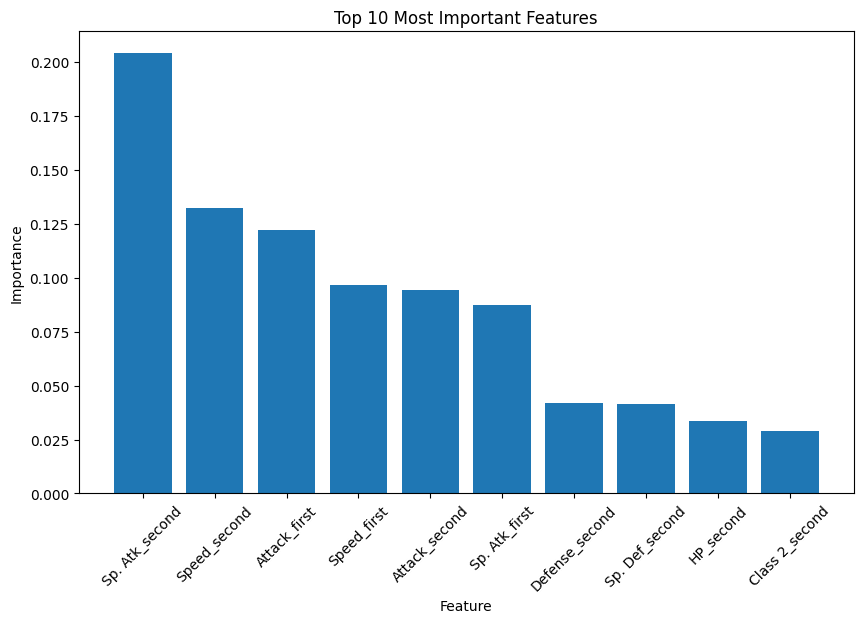

In [101]:
feature_importances = clf.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort feature importances in descending order and get the indices
indices = feature_importances.argsort()[::-1]

# Plot the top 10 most important features
top_n = 10
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[indices][:top_n], align="center")
plt.xticks(range(top_n), feature_names[indices][:top_n], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 10 Most Important Features")
plt.show()

## Question 3: Ranking - 30 points
Something the new Pokedex is missing is a smart way of ranking the Pokémon. As the dataset Professor Oak gave you contains the outcome of a large number of battles, the idea is to use this data to come up with a way of sorting the Pokémon from strongest to weakest.
1. (5 points) Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

Pokémon tournaments can be represented as a so-called _dominance graph_. The dominance graph is a directed graph in which each Pokémon is represented by one vertex, and directed edges point from stronger to weaker Pokémons: in particular, if Pokémon _i_ has won a strictly larger number of times against Pokémon _j_ than _j_ has won against _i_ (that is, if _i_ dominates _j_), there is a directed edge pointing from node _i_ to node _j_. The dominance graph can be represented as an adjacency matrix _G_ where entry _G_<sub>_ij_</sub> is 1 if there is an edge pointing from _i_ to _j_, and 0 otherwise.

2. (10 points) A simple method for identifying the strongest Pokémon using this graph is to compute the matrix _A_ = _G_ + _G_<sup>2</sup>. Consider a given row of _A_; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.
3. (7 points) Compute _A_ and extract the 10 Pokémon with the highest dominance score.
4. (3 points) Compare the ranking by dominance scores with the ranking by winning ratio (cf. subquestion 1 above). What do you observe? How do you explain the differences (if any)?
5. (5 points) Professor Oak is really keen on featuring a solid ranking mechanism in the new Pokedex, so you need to make a decision: Which scoring method is better, that based on winning ratio or that based on dominance scores? Support your opinion with explanations and examples.


# 1 
Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

In [108]:
import pandas as pd

# Calculate the number of battles for each Pokémon
battles_count = pd.concat([combats['First_pokemon'], combats['Second_pokemon']]).value_counts()

# Calculate the number of victories for each Pokémon
victories_count = combats['Winner'].value_counts()

# Calculate the winning ratio for each Pokémon
winning_ratio = victories_count / battles_count

# Combine winning ratio with Pokémon information
pokemon_winning_info = pd.DataFrame({
    'Name': pokemons['Name'],
    'WinningRatio': winning_ratio.fillna(0)  # Fill NaN values with 0 for Pokémon with no battles
})

# Show the top 10 Pokémon with the highest winning ratio
top_10_winning_pokemon = pokemon_winning_info.nlargest(10, 'WinningRatio')
print("Top 10 Pokémon with the highest winning ratio:")
print(top_10_winning_pokemon[['Name', 'WinningRatio']])


Top 10 Pokémon with the highest winning ratio:
                          Name  WinningRatio
155                    Snorlax      0.984496
513                  Magnezone      0.974790
704  Thundurus Incarnate Forme      0.968000
20                      Pidgey      0.966387
154            Mega Aerodactyl      0.964539
477                  Mismagius      0.961240
727                   Bunnelby      0.960630
717                   Genesect      0.959350
165                        Mew      0.952000
350                    Wailmer      0.950000


# 2 
A simple method for identifying the strongest Pokémon using this graph is to compute the matrix _A_ = _G_ + _G_<sup>2</sup>. Consider a given row of _A_; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.

# 3 
Compute _A_ and extract the 10 Pokémon with the highest dominance score.

In [110]:
import numpy as np
import pandas as pd

# Assuming battles is your DataFrame containing battle information
# Assuming n is the total number of Pokémon
n = max(combats['First_pokemon'].max(), combats['Second_pokemon'].max())

# Create the adjacency matrix G
G = np.zeros((n, n))
for _, battle in combats.iterrows():
    G[battle['First_pokemon'] - 1, battle['Second_pokemon'] - 1] = 1

# Compute the matrix A = G + G^2
A = G + np.dot(G, G)

# Sum up the rows to get the dominance scores
dominance_scores = np.sum(A, axis=1)

# Create a DataFrame with Pokémon ID and dominance scores
pokemon_dominance_df = pd.DataFrame({'Pokemon_ID': np.arange(1, n+1), 'Dominance_Score': dominance_scores})

# Sort the DataFrame by dominance scores in descending order
top_10_dominant_pokemon = pokemon_dominance_df.sort_values(by='Dominance_Score', ascending=False).head(10)

# Merge with the Pokémon information DataFrame to get Pokémon names
result_df = pd.merge(top_10_dominant_pokemon, pokemons[['pid', 'Name']], left_on='Pokemon_ID', right_on='pid')

# Display the result
print(result_df[['pid', 'Name', 'Dominance_Score']])


   pid       Name  Dominance_Score
0  163     Mewtwo           5499.0
1  344   Illumise           5385.0
2   71   Alakazam           5215.0
3  374   Corphish           5116.0
4   89  Magnemite           5065.0
5  657     Joltik           5039.0
6  224    Steelix           4978.0
7  369    Seviper           4948.0
8  683  Druddigon           4948.0
9   53   Parasect           4918.0


# 4 
Compare the ranking by dominance scores with the ranking by winning ratio (cf. subquestion 1 above). What do you observe? How do you explain the differences (if any)?


# 5 
Professor Oak is really keen on featuring a solid ranking mechanism in the new Pokedex, so you need to make a decision: Which scoring method is better, that based on winning ratio or that based on dominance scores? Support your opinion with explanations and examples.
